In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def analyies_sentiment(path, save_path):
    
    df = pd.read_csv(path, delimiter = '\t')
    # Create a DataFrame and print it boy.
    print("Original DataFrame:")
    print(df)

    # Drop the 'Number of sentence' column. Ich weiss nicht wieso das existieren soll. Einfach weg damit.
    df = df.drop(['id'], axis=1)

    # Calculate the Number of Sentences for a particular sentiment
    number_sentences_particular_sentiment = df['sentiment'].value_counts().sort_index()
    print("\nNumber of Sentences per Sentiment:")
    print(number_sentences_particular_sentiment)

    # Calculate the average length of sentences per sentiment
    avg_length_by_sentiment = df.groupby('sentiment')['sentence'].apply(lambda x: x.str.len().mean()).reset_index()
    avg_length_by_sentiment.rename(columns={'sentence': 'Average Sentence Length'}, inplace=True)
    print("\nAverage Sentence Length by Sentiment:")
    print(avg_length_by_sentiment)

    # Function to calculate the average word count of a list of sentences
    def avg_word_count(sentence_list):
        word_counts = [len(re.findall(r'\w+', sentence)) for sentence in sentence_list]
        return sum(word_counts) / len(word_counts)

    # Calculate the average word count per sentiment
    avg_word_count_by_sentiment = df.groupby('sentiment')['sentence'].apply(avg_word_count).reset_index()
    avg_word_count_by_sentiment.rename(columns={'sentence': 'Average Word Count'}, inplace=True)
    print("\nAverage Word Count by Sentiment:")
    print(avg_word_count_by_sentiment)

    # Merge the datasets based on the common key 'sentiment'
    merged_data_dev = pd.merge(number_sentences_particular_sentiment, avg_length_by_sentiment, left_index=True, right_on='sentiment')
    merged_data_dev = pd.merge(merged_data_dev, avg_word_count_by_sentiment, left_on='sentiment', right_on='sentiment')
    print("\nMerged Data:")
    print(merged_data_dev)

    # Save the merged dataset to a new CSV file
    merged_data_dev.to_csv(save_path, index=False)

    # Create bar graphs
    fig, ax = plt.subplots(figsize=(10, 6))
    merged_data_dev.plot(x='sentiment', kind='bar', ax=ax)
    plt.title('Comparison of Sentiment Data')
    plt.xlabel('Sentiment')
    plt.ylabel('Count / Average Length / Average Word Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [3]:
def analysis_1_0(path, save_path):
    # Load the DataFrame from the file
    df = pd.read_csv(path, delimiter='\t')
    print("Original DataFrame:")
    print(df)

    # Calculate the occurrences of each value in the 'is_duplicate' column
    value_counts = df['is_duplicate'].value_counts()

    # Calculate the length of sentences and word count
    def length_without_dots(input_string):
        length = 0
        for char in input_string:
            if char != '.':
                length += 1
        return length

    #print(df['sentence1'])
    df['sentence_length'] = length_without_dots(str(df['sentence1']))
    df['sentence_word_count'] = len(str(df['sentence1']).split())

    # Group the data by 'is_duplicate' and calculate averages
    grouped_data = df.groupby('is_duplicate').agg({
        'is_duplicate': 'count',
        'sentence_length': 'mean',
        'sentence_word_count': 'mean'
    }).rename(columns={'is_duplicate': 'Count', 'sentence_length': 'Average Sentence Length', 'sentence_word_count': 'Average Word Count'}).reset_index()

    print("\nGrouped Data:")
    print(grouped_data)

    # Create bar graphs. I guess there are no much Informations to learn from here.
    ax = grouped_data.plot(x='is_duplicate', kind='bar', figsize=(10, 6))
    ax.set_xticklabels(['Not Duplicated', 'Duplicated'], rotation=0)
    plt.title('Comparison of Duplicated and Not Duplicated Sentences')
    plt.xlabel('Is Duplicated')
    plt.ylabel('Count / Average Length / Average Word Count')
    plt.legend(["Count", "Average Sentence Length", "Average Word Count"])
    plt.tight_layout()
    plt.show()

    # Save the grouped data to a new CSV file
    grouped_data.to_csv(save_path, index=False)

In [4]:
def analysis_similarity(path, save_path):
    path = 'sts-dev.csv'
    df = pd.read_csv(path, delimiter='\t')

    # Drop the 'id' column
    df = df.drop(['id'], axis=1)

    # Calculate the Number of Sentences for a particular similarity
    number_sentences_per_similarity = df['similarity'].value_counts().sort_index()

    # Calculate the average length of sentences per similarity
    avg_length_by_similarity = (
        df.groupby('similarity')
        .apply(lambda x: x[['sentence1', 'sentence2']].apply(lambda col: col.str.len().mean()))
        .reset_index()
        .rename(columns={'sentence1': 'Avg Sentence Length 1', 'sentence2': 'Avg Sentence Length 2'})
    )

    # Calculate the absolute difference in average sentence lengths
    avg_length_diff = abs(avg_length_by_similarity['Avg Sentence Length 1'] - avg_length_by_similarity['Avg Sentence Length 2'])

    # Create a new DataFrame for the differences in sentence lengths
    new_data = pd.DataFrame({
        'similarity': avg_length_by_similarity['similarity'],
        'Avg Sentence Length Difference': avg_length_diff
    })

    # Merge the number of sentences and the differences in sentence lengths
    merged_data = pd.merge(number_sentences_per_similarity.reset_index(), new_data, on='similarity')

    # Calculate the average number of similar words
    def similar_word_count(sentence1, sentence2):
        words1 = sentence1.split()
        words2 = sentence2.split()
        common_words = Counter(words1) & Counter(words2)
        return sum(common_words.values())

    result = []

    for similarity in df['similarity'].unique():
        similar_rows = df[df['similarity'] == similarity]
        avg_word_count = similar_rows.apply(lambda row: similar_word_count(row['sentence1'], row['sentence2']), axis=1).mean()
        result.append({'similarity': similarity, 'avg_word_count': avg_word_count})

    result_df = pd.DataFrame(result)
    result_df = result_df.sort_values(by='similarity')  # Sort by the 'similarity' column

    # Merge 'merged_data' and 'result_df'
    final_result = pd.merge(merged_data, result_df, on='similarity')
    print(final_result)



    # Set the figure size to enlarge the x-axis
    plt.figure(figsize=(100, 600))

    # Plot a bar graph
    final_result.plot(x='similarity', kind='bar')
    plt.ylabel('Values')  # Set y-axis label
    plt.xlabel('Similarity')  # Set x-axis label
    plt.title('Bar Graph of Final Result')  # Set title

    plt.show()  # Show the plot
    
    #save Data
    final_result.to_csv(save_path, index=False)

In [5]:
# Classify in 11 Classes of Similarity [0>,>=0.5,1>,>=1.5,>2,>=2.5,>3,>=3.5,>4,>=4.5,=5]:
def Analysis_on_analysed_similarity(path, save_path):
    # Creating the DataFrame
    data = pd.read_csv(path, delimiter=',')
    # Define the ranges for initial splitting
    similarity_ranges = [(i, i + 1) for i in range(0, 6)]

    # Initialize a dictionary to store the splitted DataFrames
    splitted_dataframes = {}

    # Split the data into different DataFrames based on the initial similarity ranges
    for j, (lower, upper) in enumerate(similarity_ranges, start=1):
        splitted_dataframes[f'data_{j}'] = data[(data['similarity'] >= lower) & (data['similarity'] < upper)]

    # Initialize a dictionary to store the final splitted DataFrames
    final_splitted_dataframes = {}

    # Split each of the previously splitted DataFrames further
    for df_name, df in splitted_dataframes.items():
        sub_dataframes = {}
        for j in range(-1, 6):
            sub_df_name = f'{df_name}_sub_{j}'
            if j < 5:
                sub_data = df[(df['similarity'] >= j + 0.5) & (df['similarity'] < j + 1.5)]
            else:
                sub_data = df[(df['similarity'] >= j + 0.5)]

            if not sub_data.empty:  # Check if the DataFrame is not empty
                sub_dataframes[sub_df_name] = sub_data

        if sub_dataframes:  # Check if there are non-empty sub-DataFrames
            final_splitted_dataframes[df_name] = sub_dataframes


    # Perform analysis and create the 'result' DataFrame
    result_data = []

    for df_name, sub_dataframes in final_splitted_dataframes.items():
        for sub_df_name, sub_df in sub_dataframes.items():
            mean_similarity = sub_df['similarity'].mean()
            mean_count = sub_df['count'].mean()
            mean_avg_sentence_length_diff = sub_df['Avg Sentence Length Difference'].mean()
            mean_avg_word_count = sub_df['avg_word_count'].mean()

            result_data.append([mean_similarity, mean_count, mean_avg_sentence_length_diff, mean_avg_word_count])

    result_columns = ['mean similarity', 'mean count', 'mean Avg Sentence Length Difference', 'mean avg_word_count']
    result_df = pd.DataFrame(result_data, columns=result_columns)


    # Save 
    result_df.to_csv(save_path, index=False)
    # Print the 'result' DataFrame
    print("result:")
    print(result_df)
    
    # Set the figure size to enlarge the x-axis
    plt.figure(figsize=(10, 6))

    # Plot a bar graph
    result_df.plot(x='mean similarity', kind='bar')
    plt.ylabel('Values')  # Set y-axis label
    plt.xlabel('mean similarity')  # Set x-axis label
    plt.title('Final Results of analysing the analyised Similarties data_set')  # Set title

    plt.show()  # Show the plot

In [6]:
# Just to see the unique values in the last column 
def uniq_values(path):
    # Load your dataset using pandas
    df = pd.read_csv(path, delimiter='\t')
    # Get the unique values in the last column (assuming it's the 'Name' column in this example)
    unique_values = sorted(set(df.iloc[:, -1]))  # Assuming the last column is the one you're interested in
    return unique_values

In [7]:
# Let it be filterd. We want to remove all rows where pred_similarity and true values are the same
def filter_rows(path):
    data = pd.read_csv(path, delimiter=',')
    filtered_data = data[data.iloc[:, -2] != data.iloc[:, -1]] 
    
    save_path = f"filtered_{path}"  
    filtered_data.to_csv(save_path, index=False)
    
    print("Filtered Data:")
    print(filtered_data)
    
    return filtered_data
# filter_rows('merged_quora-dev.csv_CenterMatrixLinearSelfAttentionWithSparsemax-para-dev-output.csv.csv')

In [8]:
# Merge Function. Sounds dumm, but I forget why I needed it at the first place.
def merge_and_save(path_1, path_2):
    data_1 = pd.read_csv(path_1, delimiter='\t')
    data_2 = pd.read_csv(path_2, delimiter=',')
    column_name = data_1.columns[-1]
    #merged_data = pd.merge(data_1, data_2, on=column_name)
    merged_data = pd.merge(data_1, data_2)
    print("\nMerged Data:")
    print(merged_data)
    save_path = f"merged_{path_1}_{path_2}.csv" 
    merged_data.to_csv(save_path, index=False)
    print(f"Merged data saved to {save_path}")

Original DataFrame:
      Unnamed: 0                         id   
0              0  a7d575c9ed86ea9633660c67e  \
1              1  33cfa32975091f471e3a19656   
2              2  266dc1a26e2654235e8d8dd22   
3              3  9ab97ed33b3aae716a099a622   
4              4  b9a4de27c4cb2a0f8fa220747   
...          ...                        ...   
1096        1096  7268beb9989f19b75e1395ec5   
1097        1097  54276f810c53354928acf961a   
1098        1098  a6744ae0fdcf6e2edf582f6c6   
1099        1099  8a5012744199a4ea506bc96df   
1100        1100  1ae91087064d5035fe6c0c63f   

                                               sentence  sentiment  
0      It 's a lovely film with lovely performances ...          3  
1      No one goes unindicted here , which is probab...          2  
2      And if you 're not nearly moved to tears by a...          3  
3                      A warm , funny , engaging film .          4  
4      Uses sharp humor and insight into human natur...          4  
.

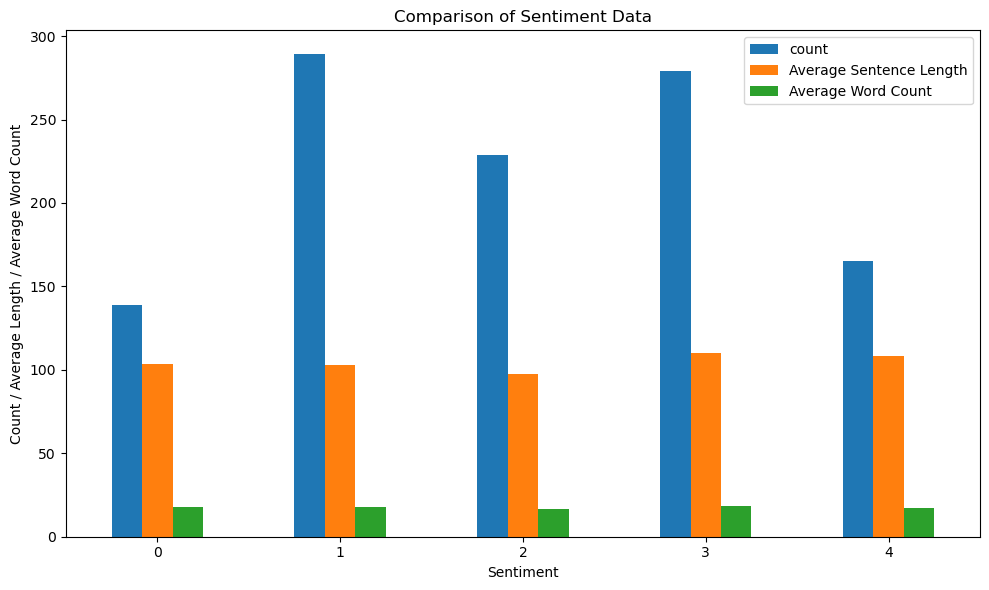

In [9]:
analyies_sentiment('ids-sst-dev.csv', 'Analysis_ids-sst-dev.csv')

Original DataFrame:
      Unnamed: 0                         id   
0              0  32a4f146782cbde1b7fa65799  \
1              1  6e0fb51a6fefc7c1b6d77a1d5   
2              2  9b1d25f272afcc21d4508f652   
3              3  40ad03c7e89899424ed723b96   
4              4  1ade8c062b919bec94fb66db9   
...          ...                        ...   
8539        8539  0e985aea48c6fb43641761bd5   
8540        8540  0c55fde1238b0a068cc30e44a   
8541        8541  c55e4c17dc18975f9e574c787   
8542        8542  a6d7e3b0643710275f4ed61b4   
8543        8543  69121a33e2470c0b0b28cceee   

                                               sentence  sentiment  
0      The Rock is destined to be the 21st Century '...          3  
1      The gorgeously elaborate continuation of `` T...          4  
2      Singer\/composer Bryan Adams contributes a sl...          3  
3      You 'd think by now America would have had en...          2  
4                  Yet the act is still charming here .          3  
.

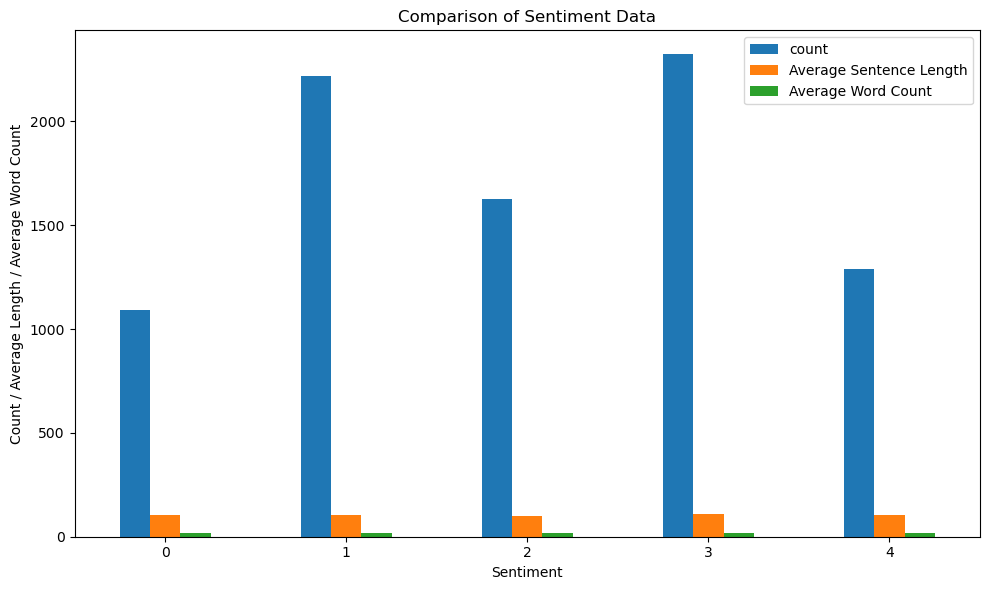

In [10]:
analyies_sentiment('ids-sst-train.csv', 'Analysis_ids-sst-train.csv')

Original DataFrame:
       Unnamed: 0                         id   
0          290564  fbfddc56315fb8a39e7608fa0  \
1          318737  318658e273ac78f3b1e957b8b   
2          400012  b229a7f7a7b661a8a92f970cf   
3          346961  6d1af8d3227bcb1f12e5fd17f   
4          103882  8e17f5f485c42beec87bbe341   
...           ...                        ...   
20209      287156  66a81f1fb357b3a02cf56af53   
20210      374866  97caffa7ec889385d3aa3a761   
20211      222710  d7111c39ead9759d48cd7cf4b   
20212      272833  d8511a7a0514299f18fcef14d   
20213      111373  43fb8a68c4664400b42db7f83   

                                               sentence1   
0       What can you get as a customer of Star Alliance?  \
1      "Which is correct grammar: I graduated from Un...   
2                                  What makes one angry?   
3      What can Trump realistically do for America (i...   
4      I have 95% in 10th, 95% in 12th and CGPA 7.8 i...   
...                                        

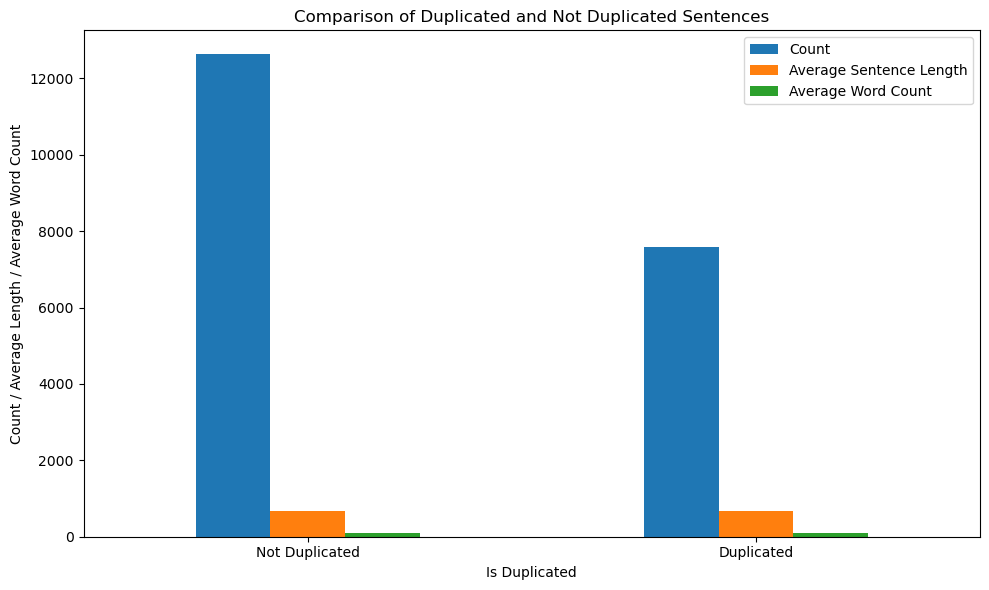

In [11]:
analysis_1_0('quora-dev.csv', 'Analysis_quora_dev.csv')

Original DataFrame:
        Unnamed: 0                         id   
0           321296  a4da64a4e943bf8b008d174ca  \
1           373075  f965ab2d29d51008ab3872f47   
2           213557  5aca073f4a977d55176f68572   
3           209343  a8abbd08d3401287da42acfb9   
4           389061  65dffaf8ac0ed7f3ebfcf0b02   
...            ...                        ...   
141501      402090  837a6b4ec23cabe215a141b15   
141502      376186  c1a62a4587067ed59be67855c   
141503      116568  a131d77690c3fd161914940b1   
141504       84800  652c65311af308afa9f257244   
141505      209926  4fd4acbc7b6471bfad73bb69d   

                                                sentence1   
0                    How can I master myself in geometry?  \
1         Can deleted pictures on Instagram be recovered?   
2       Who is the best prime minister India has ever ...   
3       What qualifications do I need to get a job in ...   
4                   In what situations is it okay to lie?   
...                      

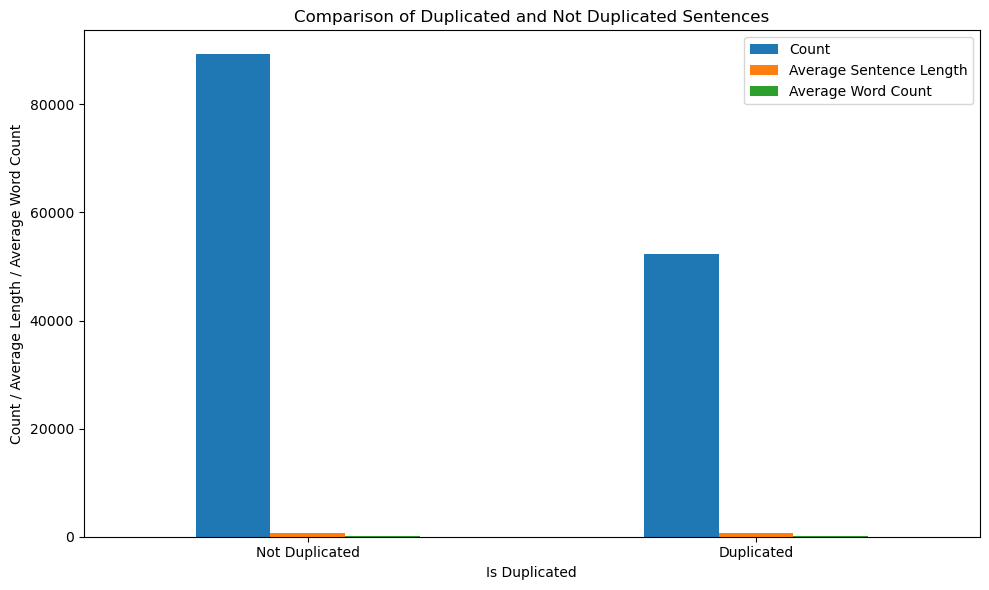

In [12]:
analysis_1_0('quora-train.csv', 'train.csv')

    similarity  count  Avg Sentence Length Difference  avg_word_count
0        0.000     59                        2.254237        2.050847
1        0.200     11                        8.636364        2.545455
2        0.231      1                        1.000000        2.000000
3        0.250      2                        6.500000        2.000000
4        0.300      1                        0.000000        2.000000
..         ...    ...                             ...             ...
57       4.600     17                        1.235294        5.411765
58       4.750      4                        4.750000       12.000000
59       4.800     22                        1.227273        6.090909
60       4.875      1                        4.000000        4.000000
61       5.000     52                        0.307692        5.480769

[62 rows x 4 columns]


<Figure size 10000x60000 with 0 Axes>

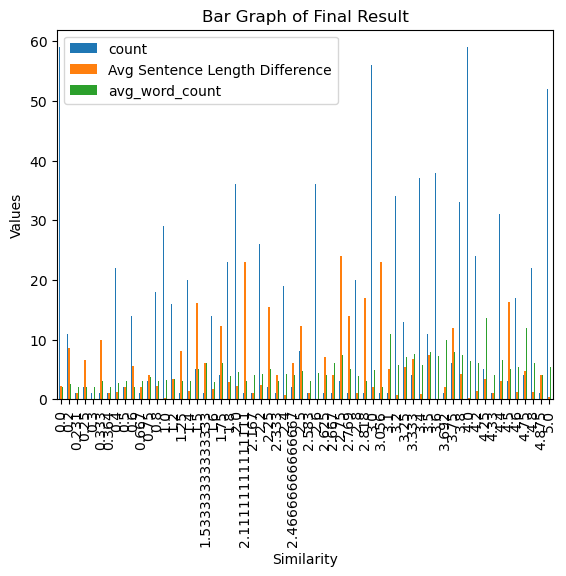

In [13]:
analysis_similarity('sts-dev.csv', 'Analysis_sts-dev.csv')

    similarity  count  Avg Sentence Length Difference  avg_word_count
0        0.000     59                        2.254237        2.050847
1        0.200     11                        8.636364        2.545455
2        0.231      1                        1.000000        2.000000
3        0.250      2                        6.500000        2.000000
4        0.300      1                        0.000000        2.000000
..         ...    ...                             ...             ...
57       4.600     17                        1.235294        5.411765
58       4.750      4                        4.750000       12.000000
59       4.800     22                        1.227273        6.090909
60       4.875      1                        4.000000        4.000000
61       5.000     52                        0.307692        5.480769

[62 rows x 4 columns]


<Figure size 10000x60000 with 0 Axes>

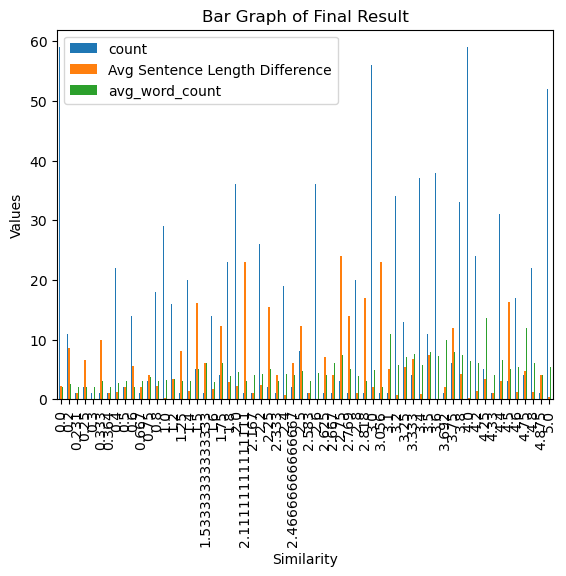

In [14]:
analysis_similarity('sts-train.csv', 'Analysis_sts-train.csv')

result:
    mean similarity  mean count  mean Avg Sentence Length Difference   
0          0.259750   12.250000                             3.815871  \
1          0.663400    7.600000                             3.173016   
2          1.212500   16.500000                             3.242349   
3          1.636667    9.400000                             7.821056   
4          2.240972   11.000000                             6.850216   
5          2.679111    8.000000                             8.919753   
6          3.191286   20.857143                             6.263472   
7          3.668400   17.800000                             5.149920   
8          4.236000   24.000000                             1.823694   
9          4.705000    9.400000                             5.509180   
10         5.000000   52.000000                             0.307692   

    mean avg_word_count  
0              2.284765  
1              2.955556  
2              3.157974  
3              4.777019

<Figure size 1000x600 with 0 Axes>

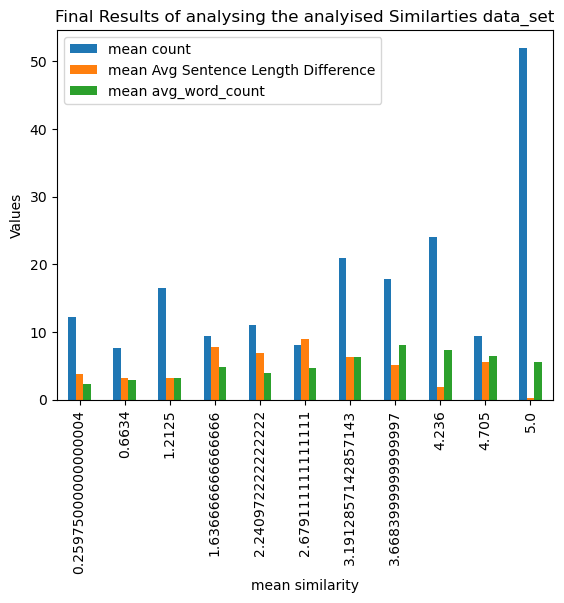

In [15]:
Analysis_on_analysed_similarity('Analysis_sts-dev.csv', 'Analysis_on_analysed_similarity-dev.csv')